# Stock Price Prediction - LSTM

## 1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as random
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input

from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
# Fix random seed for reproducibility
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

## 2. Data Collection

In [3]:
# Import historical stock price data for Apple from 2015 to 2019

# Define the stock ticker and date range
ticker = 'AAPL'
start_date = '2015-01-02'
end_date = '2019-12-31'

# Retrieve historical stock data
apple_stock_data = yf.download(ticker, start=start_date, end=end_date)

# Convert the index to a datetime format
apple_stock_data.index = pd.to_datetime(apple_stock_data.index)

# Display the data
apple_stock_data


[*********************100%%**********************]  1 of 1 completed


Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2015-01-02  27.847500  27.860001  26.837500  27.332500  24.373957  212818400
2015-01-05  27.072500  27.162500  26.352501  26.562500  23.687305  257142000
2015-01-06  26.635000  26.857500  26.157499  26.565001  23.689535  263188400
2015-01-07  26.799999  27.049999  26.674999  26.937500  24.021708  160423600
2015-01-08  27.307501  28.037500  27.174999  27.972500  24.944683  237458000
...               ...        ...        ...        ...        ...        ...
2019-12-23  70.132500  71.062500  70.092499  71.000000  68.908974   98572000
2019-12-24  71.172501  71.222504  70.730003  71.067497  68.974503   48478800
2019-12-26  71.205002  72.495003  71.175003  72.477501  70.342979   93121200
2019-12-27  72.779999  73.492500  72.029999  72.449997  70.316292  146266000
2019-12-30  72.364998  73.172501  71.305000  72.879997  70.733620  144114400

[1257 rows x 6 columns]

## 3. Data Preprocessing

In [4]:
# Check for missing values in the dataset
missing_data = apple_stock_data.isnull().sum()
print("Missing data before reindexing:\n", missing_data)

Missing data before reindexing:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [5]:
# Apply linear interpolation to fill missing values (if any)

# Create a full date range for the given period (including weekends/holidays)
full_date_range = pd.date_range(start=start_date, end=end_date, freq='D')
apple_stock_data_full = apple_stock_data.reindex(full_date_range)

# Interpolate the missing data using linear method
apple_stock_data_interpolated = apple_stock_data_full.interpolate(method='linear')
apple_stock_data_cleaned = apple_stock_data_interpolated.dropna()

# Check for any remaining missing data
missing_data_after = apple_stock_data_cleaned.isnull().sum()
print("Missing data after preprocessing:\n", missing_data_after)

# Display the cleaned data and check the first 15 rows
print("Cleaned data after interpolation and dropping NaNs:\n")
apple_stock_data_cleaned.head()

Missing data after preprocessing:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Cleaned data after interpolation and dropping NaNs:



Open       High        Low      Close  Adj Close  \
2015-01-02  27.847500  27.860001  26.837500  27.332500  24.373957   
2015-01-03  27.589167  27.627501  26.675833  27.075834  24.145073   
2015-01-04  27.330833  27.395000  26.514167  26.819167  23.916189   
2015-01-05  27.072500  27.162500  26.352501  26.562500  23.687305   
2015-01-06  26.635000  26.857500  26.157499  26.565001  23.689535   

                  Volume  
2015-01-02  2.128184e+08  
2015-01-03  2.275929e+08  
2015-01-04  2.423675e+08  
2015-01-05  2.571420e+08  
2015-01-06  2.631884e+08

In [6]:
apple_stock_dates = apple_stock_data_cleaned.reset_index()

# Rename the column to 'Date' if yfinance didn't set a proper header
apple_stock_dates.rename(columns={'index': 'Date'}, inplace=True)
apple_stock_dates.head()

Date       Open       High        Low      Close  Adj Close  \
0 2015-01-02  27.847500  27.860001  26.837500  27.332500  24.373957   
1 2015-01-03  27.589167  27.627501  26.675833  27.075834  24.145073   
2 2015-01-04  27.330833  27.395000  26.514167  26.819167  23.916189   
3 2015-01-05  27.072500  27.162500  26.352501  26.562500  23.687305   
4 2015-01-06  26.635000  26.857500  26.157499  26.565001  23.689535   

         Volume  
0  2.128184e+08  
1  2.275929e+08  
2  2.423675e+08  
3  2.571420e+08  
4  2.631884e+08

After applying linear interpolation, the missing values were successfully filled, resulting in a clean dataset with no further missing data. This step ensures the continuity of the time series data, which is crucial for accurate stock price prediction.

## 4. Data Visualization

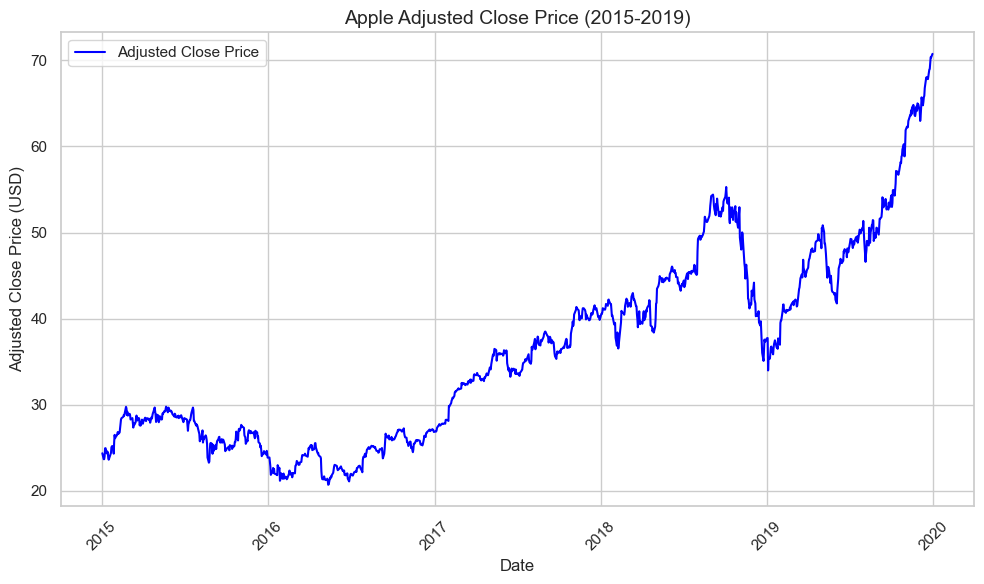

In [7]:
# Set the style for the plot
sns.set(style="whitegrid")

# Plot the adjusted close price over time
plt.figure(figsize=(10, 6))
plt.plot(apple_stock_data.index, apple_stock_data['Adj Close'], color='blue', label='Adjusted Close Price')
plt.title('Apple Adjusted Close Price (2015-2019)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Adjusted Close Price (USD)', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


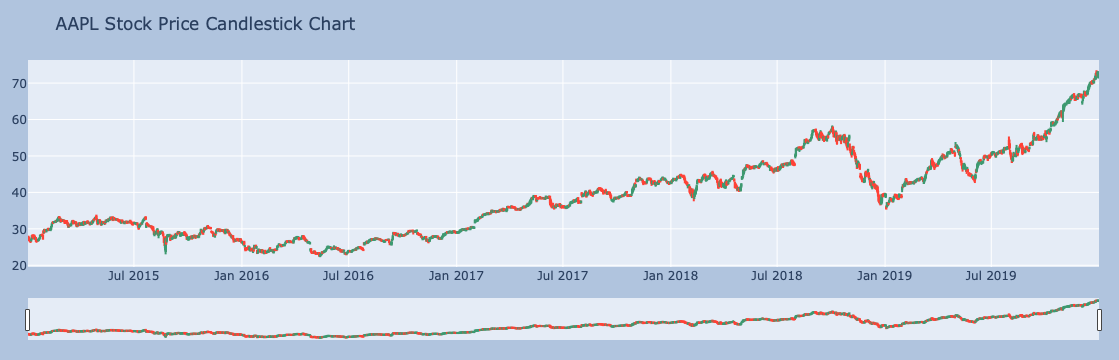

In [8]:
# Use the cleaned data DataFrame
temp_df = apple_stock_data_cleaned.copy()

# Create the candlestick chart
fig = go.Figure(
    data=[
        go.Candlestick(
            x=temp_df.index,
            open=temp_df["Open"],
            high=temp_df["High"],
            low=temp_df["Low"],
            close=temp_df["Close"],
        )
    ]
)

# Update layout for better visualization
fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    height=600,  # Adjust the height as needed
    paper_bgcolor="LightSteelBlue",
    title="AAPL Stock Price Candlestick Chart",
)

# Show the chart
fig.show()


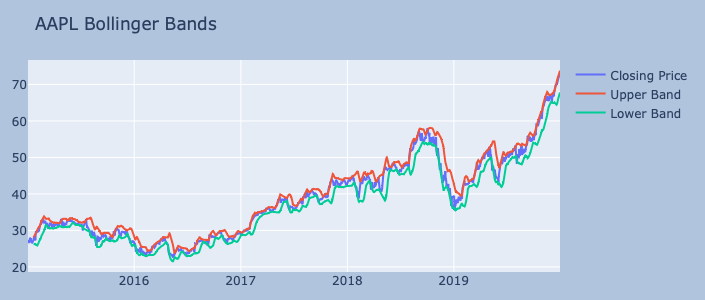

In [9]:
temp_df['SMA_20'] = temp_df['Close'].rolling(window=20).mean()
temp_df['STD_20'] = temp_df['Close'].rolling(window=20).std()
temp_df['Upper Band'] = temp_df['SMA_20'] + (temp_df['STD_20'] * 2)
temp_df['Lower Band'] = temp_df['SMA_20'] - (temp_df['STD_20'] * 2)

fig = go.Figure()
fig.add_trace(go.Scatter(x=temp_df.index, y=temp_df['Close'], mode='lines', name='Closing Price'))
fig.add_trace(go.Scatter(x=temp_df.index, y=temp_df['Upper Band'], mode='lines', name='Upper Band'))
fig.add_trace(go.Scatter(x=temp_df.index, y=temp_df['Lower Band'], mode='lines', name='Lower Band'))

fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    height=300,
    paper_bgcolor="LightSteelBlue",
    title="AAPL Bollinger Bands"
)

fig.show()


Bollinger Bands are used to identify volatility of the stock prices. It shows if a stock was potentially overbought or oversold  by showing how price moves relative to its moving average. When the price moves outside the bands, it indicates a potential reversal or continuation in the trend.

- For AAPL however, this seems pretty stable

## 5. LSTM Model Build

In [10]:
# Determine the split indices
total_length = len(apple_stock_data_cleaned)
train_end = round(0.7 * total_length)
val_end = train_end + round(0.15 * total_length)

# Split the data
train_data = apple_stock_data_cleaned[:train_end].iloc[:,4:5]
val_data = apple_stock_data_cleaned[train_end:val_end].iloc[:,4:5]
test_data = apple_stock_data_cleaned[val_end:].iloc[:,4:5]

# Display the sizes of each dataset
print(f"Training set size (70%): {len(train_data)}")
print(f"Validation set size (15%): {len(val_data)}")
print(f"Test set size (15%): {len(test_data)}")

Training set size (70%): 1278
Validation set size (15%): 274
Test set size (15%): 273


In [11]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

# Fit the scaler on the training data and transform it
train_data_scaled = scaler.fit_transform(train_data)

# Transform the validation and test data using the same scaler
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)

# Display the first few rows of the scaled datasets
print("Scaled Training data:\n", train_data_scaled[:5])
print("Scaled Validation data:\n", val_data_scaled[:5])
print("Scaled Test data:\n", test_data_scaled[:5])

Scaled Training data:
 [[0.144268  ]
 [0.13523096]
 [0.12619392]
 [0.11715689]
 [0.11724492]]
Scaled Validation data:
 [[0.90571212]
 [0.91264791]
 [0.9195837 ]
 [0.94367112]
 [0.95182517]]
Scaled Test data:
 [[1.03358029]
 [1.03680287]
 [1.04921996]
 [1.05901477]
 [1.06880958]]


In [12]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# Define the sequence length
sequence_length = 30  # Number of time steps in each sequence

# Create sequences for training, validation, and test sets
X_train, y_train = create_sequences(train_data_scaled, sequence_length)
X_val, y_val = create_sequences(val_data_scaled, sequence_length)
X_test, y_test = create_sequences(test_data_scaled, sequence_length)

# Display the shapes of the created sequences
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (1248, 30, 1)
y_train shape: (1248, 1)
X_val shape: (244, 30, 1)
y_val shape: (244, 1)
X_test shape: (243, 30, 1)
y_test shape: (243, 1)


In [13]:
# Define the LSTM model
def create_lstm_model(input_shape, num_of_units, dropout_ratio, summary):
    lstm_model = Sequential()
    lstm_model.add(Input(shape=(X_train.shape[1], 1)))
    lstm_model.add(LSTM(num_of_units, return_sequences= True))
    lstm_model.add(Dropout(dropout_ratio))
    lstm_model.add(LSTM(num_of_units, return_sequences= False))
    lstm_model.add(Dropout(dropout_ratio))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer = "adam", loss = "mean_squared_error")
    if summary==True:
        lstm_model.summary()
    return lstm_model

# Define input shape
input_shape = (X_train.shape[1], 1)  # (sequence_length, number of features)

In [14]:
# Train the LSTM model with early stopping
def train_lstm_model(model, batch_size, epochs, verbose):
    # Set up early stopping to monitor validation loss and restore best weights
    # patience (int) – Number of events to wait if no improvement and then stop the training.
    # verbose displays messages when the callback takes an action
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)
    history = model.fit(
        X_train, 
        y_train, 
        validation_data=(X_val, y_val),
        epochs=100, 
        batch_size=batch_size, 
        callbacks=[early_stop],
        verbose=verbose
    )
    return history

In [15]:
# Plot learning curve function
def plot_learning_curve(history, batch_size, ax=None):  # Uniform scale
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    if ax is None:
        plt.figure(figsize=(10, 6))
        ax = plt.gca()
    ax.plot(train_loss, label=f'Train Loss (Batch Size: {batch_size})')
    ax.plot(val_loss, label=f'Val Loss (Batch Size: {batch_size})')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss (MSE)')
    ax.legend()
    # ax.set_ylim(ylim)  # Set same y-axis limits for all plots

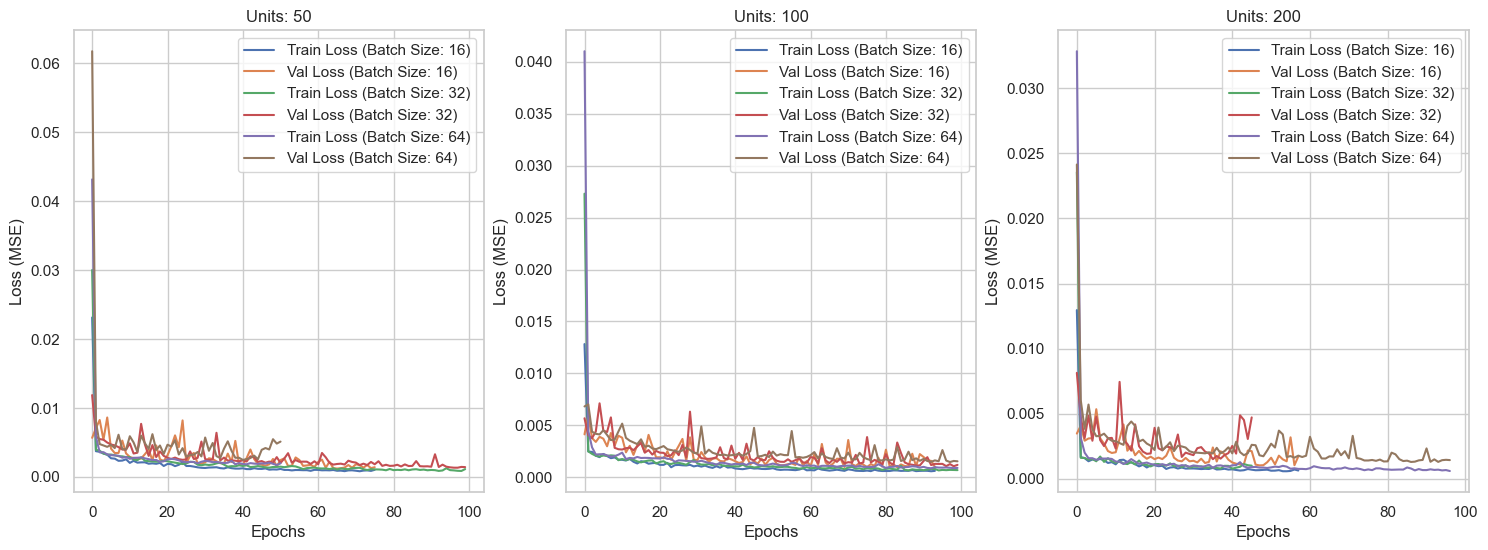

Best combinations based on Avg Validation Loss and Gap:


Units  Batch Size  Avg Train Loss  Avg Val Loss       Gap
0    100          32        0.000696      0.001174  0.000478
1     50          32        0.000958      0.001383  0.000425
2    200          64        0.000667      0.001431  0.000764
3     50          16        0.000912      0.001492  0.000580
4    100          16        0.000609      0.001676  0.001066
5    100          64        0.000910      0.001758  0.000848
6    200          16        0.000631      0.001764  0.001133
7    200          32        0.001000      0.003825  0.002825
8     50          64        0.001918      0.004715  0.002797

In [16]:
# Different batch sizes to try
batch_sizes = [16, 32, 64]
units_list = [50, 100, 200]

# To store results for each combination
results = []

# Set a common y-axis scale for the plots
# common_ylim = (0, 0.07)
# Plot for each units value (3 graphs, 1 for each units value)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

for i, units in enumerate(units_list):
    ax = axes[i]
    for batch_size in batch_sizes:
        # Train model with the specific combination
        model = create_lstm_model(input_shape, num_of_units=units, dropout_ratio=0.2, summary=False)
        history = train_lstm_model(model=model, batch_size=batch_size, epochs=100,verbose=0)
        # Plot learning curve
        plot_learning_curve(history, batch_size, ax=ax)

        # Calculate the average loss for training and validation (last 5 epochs)
        avg_train_loss = np.mean(history.history['loss'][-5:])
        avg_val_loss = np.mean(history.history['val_loss'][-5:])
        gap = avg_val_loss - avg_train_loss

        # Store results: (units, batch_size, avg_train_loss, avg_val_loss, gap)
        results.append((units, batch_size, avg_train_loss, avg_val_loss, gap))
    
    ax.set_title(f'Units: {units}')

plt.show()

# Analyzing the best combination based on minimal loss and gap
results_df = pd.DataFrame(results, columns=['Units', 'Batch Size', 'Avg Train Loss', 'Avg Val Loss', 'Gap'])
results_df_sorted = results_df.sort_values(by=['Avg Val Loss', 'Gap'])
results_df_sorted = results_df_sorted.reset_index(drop=True)

# Display the sorted DataFrame
print("Best combinations based on Avg Validation Loss and Gap:")
results_df_sorted


In [17]:
# Create the LSTM model
model = create_lstm_model(input_shape, num_of_units=100, dropout_ratio=0.2, summary=True)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 30, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = train_lstm_model(model=model, batch_size=32, epochs=100,verbose=1)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0728 - val_loss: 0.0063
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0035 - val_loss: 0.0055
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0024 - val_loss: 0.0047
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0025 - val_loss: 0.0040
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0025 - val_loss: 0.0041
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0022 - val_loss: 0.0036
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0019 - val_loss: 0.0034
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0019 - val_loss: 0.0046
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0022 - val_loss: 0.0036
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0021 - val_loss: 0.0041
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 12/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

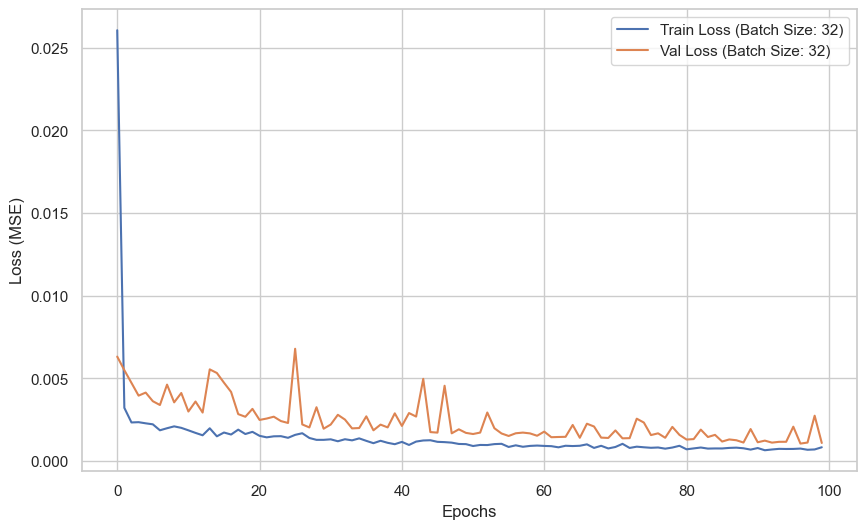

In [19]:
plot_learning_curve(history, batch_size=32, ax=None)

Above graph suggests that there is no significant overfitting done on the training dataset

In [20]:
# Make predictions using the trained LSTM model
predictions_train = model.predict(X_train)
predictions_valid = model.predict(X_val)
predictions_test = model.predict(X_test)

# Rescale predictions and actual values back to their original scale
predictions_train_original = scaler.inverse_transform(predictions_train)
predictions_valid_original = scaler.inverse_transform(predictions_valid)
predictions_test_original = scaler.inverse_transform(predictions_test)

actual_train_original = scaler.inverse_transform(y_train)
actual_valid_original = scaler.inverse_transform(y_val)
actual_test_original = scaler.inverse_transform(y_test)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [21]:
# Display the first few values to verify
print("Predictions on training data:\n", predictions_train_original[:5])
print("Actual training data labels:\n", actual_train_original[:5])
print("Predictions on validation data:\n", predictions_valid_original[:5])
print("Actual validation data labels:\n", actual_valid_original[:5])
print("Predictions on test data:\n", predictions_test_original[:5])
print("Actual test data labels:\n", actual_test_original[:5])

Predictions on training data:
 [[26.257624]
 [26.34809 ]
 [26.407629]
 [26.432997]
 [26.51613 ]]
Actual training data labels:
 [[26.33805275]
 [26.44729042]
 [26.45175934]
 [26.65462685]
 [26.84487534]]
Predictions on validation data:
 [[46.699818]
 [48.548553]
 [49.508408]
 [49.69465 ]
 [49.56387 ]]
Actual validation data labels:
 [[49.2306366 ]
 [49.37306976]
 [49.45852661]
 [49.54398346]
 [49.62944031]]
Predictions on test data:
 [[50.12978 ]
 [50.657177]
 [50.67865 ]
 [50.397137]
 [50.037495]]
Actual test data labels:
 [[50.8350029 ]
 [50.57332484]
 [50.31164678]
 [50.04996872]
 [48.70077133]]


## 6. Performance Evaluation

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

# Calculate performance metrics
mse_train = mean_squared_error(actual_train_original, predictions_train_original)
mse_valid = mean_squared_error(actual_valid_original, predictions_valid_original)
mse_test = mean_squared_error(actual_test_original, predictions_test_original)

mape_train = mean_absolute_percentage_error(actual_train_original, predictions_train_original)
mape_valid = mean_absolute_percentage_error(actual_valid_original, predictions_valid_original)
mape_test = mean_absolute_percentage_error(actual_test_original, predictions_test_original)

r2_train = r2_score(actual_train_original, predictions_train_original)
r2_valid = r2_score(actual_valid_original, predictions_valid_original)
r2_test = r2_score(actual_test_original, predictions_test_original)

# Create a DataFrame for better readability
import pandas as pd

performance_metrics = pd.DataFrame({
    'Metric': ['MSE', 'MAPE', 'R²'],
    'Training': [mse_train, mape_train, r2_train],
    'Validation': [mse_valid, mape_valid, r2_valid],
    'Test': [mse_test, mape_test, r2_test]
})

print(performance_metrics)


  Metric  Training  Validation      Test
0    MSE  0.170396    0.682905  1.456814
1   MAPE  0.009484    0.013258  0.016370
2     R²  0.996362    0.981402  0.975440


As expected, the best performance (lowest MSE, and highesr R2) is for the Training set, followed by performance of Validation and Test Set

In [23]:
# Create a function to plot predictions vs. actual values with dates and shift for sequence length
def plot_predictions_vs_actual(actual, predicted, title, dates, sequence_length, color_actual='blue', color_predicted='red'):
    plt.figure(figsize=(8, 4))
    
    # Adjust dates to account for the sequence length (shifting by sequence length)
    shifted_dates = dates[sequence_length:]
    
    # Plot actual and predicted values with corresponding shifted dates
    plt.plot(shifted_dates, actual, label='Actual', color=color_actual, linestyle='-', marker='o', markersize=3)
    plt.plot(shifted_dates, predicted, label='Predicted', color=color_predicted, linestyle='--', marker='x', markersize=3)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

# Set sequence length
sequence_length = 30

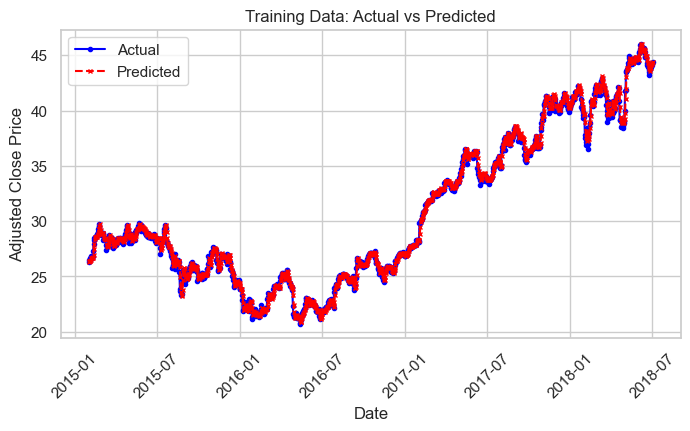

In [24]:
# Plot for Training Data
plot_predictions_vs_actual(actual_train_original, 
                           predictions_train_original, 
                           'Training Data: Actual vs Predicted', 
                           apple_stock_dates['Date'][:train_end], 
                           sequence_length
                          )

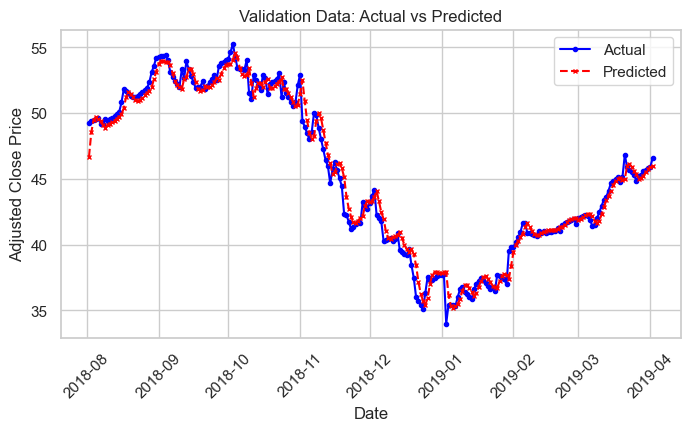

In [25]:
# Plot for Validation Data
plot_predictions_vs_actual(actual_valid_original, 
                           predictions_valid_original, 
                           'Validation Data: Actual vs Predicted', 
                           apple_stock_dates['Date'][train_end:val_end], 
                           sequence_length
                          )

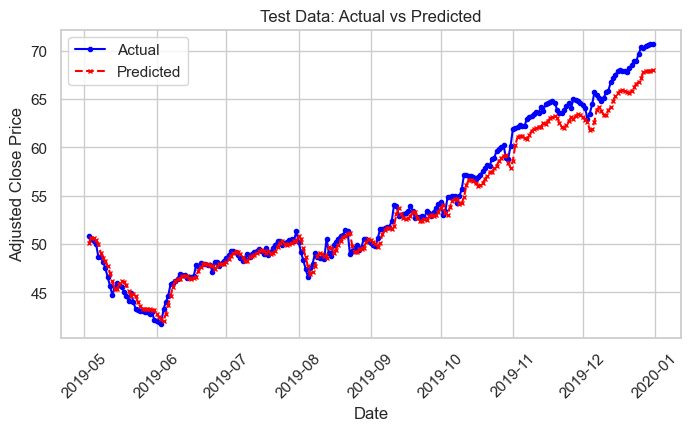

In [26]:
# Plot for Test Data
plot_predictions_vs_actual(actual_test_original, 
                           predictions_test_original, 
                           'Test Data: Actual vs Predicted', 
                           apple_stock_dates['Date'][val_end:], 
                           sequence_length
                          )

In [27]:
def create_dataframe(dates, actual, predicted):
    return pd.DataFrame({
        'Date': dates,
        'Actual': actual.flatten(),
        'Predicted': predicted.flatten()
    })

def plot_predictions_vs_actual(dates, actual, predicted, label_actual, label_predicted, color_actual, color_predicted):
    plt.plot(dates, actual, label=label_actual, color=color_actual, linestyle='-', marker='o', markersize=3)
    plt.plot(dates, predicted, label=label_predicted, color=color_predicted, linestyle='--', marker='x', markersize=2)

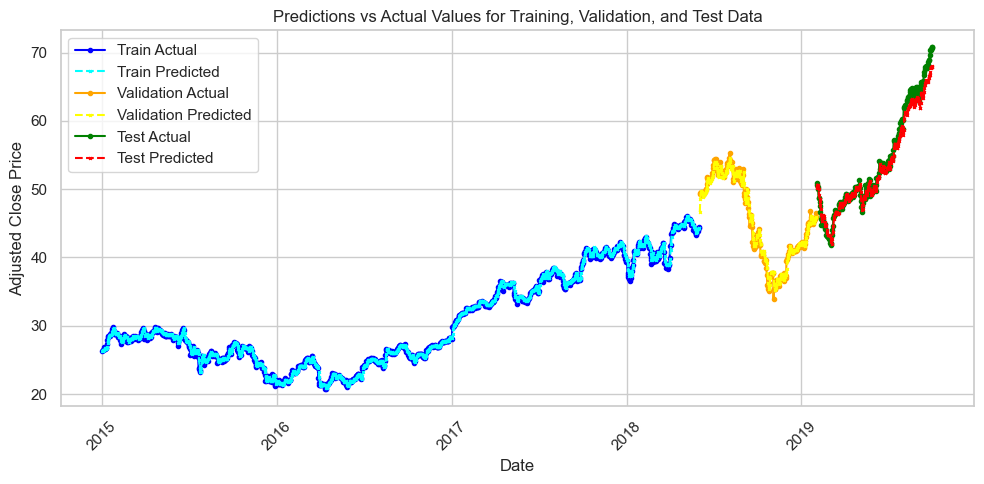

In [28]:
# Combined performance graph of predictions over actual data
# Define the sequence length and calculate indices
sequence_length = 30

# Make sure that the indices are aligned with the original dates for each dataset
dates_train = apple_stock_data_cleaned.index[:len(actual_train_original)]
dates_valid = apple_stock_data_cleaned.index[len(actual_train_original):len(actual_train_original) + len(actual_valid_original)]
dates_test = apple_stock_data_cleaned.index[len(actual_train_original) + len(actual_valid_original):len(actual_train_original) + len(actual_valid_original) + len(actual_test_original)]

# Create DataFrames for plotting with correct lengths
# Create DataFrames for plotting with correct lengths
df_train = create_dataframe(dates_train,actual_train_original,predictions_train_original)
df_valid = create_dataframe(dates_valid,actual_valid_original,predictions_valid_original)
df_test = create_dataframe(dates_test,actual_test_original,predictions_test_original)

# Plot the combined data
plt.figure(figsize=(10, 5))

# Plot training data

plot_predictions_vs_actual(df_train['Date'], df_train['Actual'], df_train['Predicted'], 'Train Actual', 'Train Predicted', 'blue', 'cyan')
plot_predictions_vs_actual(df_valid['Date'], df_valid['Actual'], df_valid['Predicted'], 'Validation Actual', 'Validation Predicted', 'orange', 'yellow')
plot_predictions_vs_actual(df_test['Date'], df_test['Actual'], df_test['Predicted'], 'Test Actual', 'Test Predicted', 'green', 'red')

# Formatting the plot
plt.title('Predictions vs Actual Values for Training, Validation, and Test Data')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
